In [14]:

import process_gens
import pandas as pd
from helm.benchmark.runner import InstanceGenerations,GenerationSummary
from typing import Any, List
import json
from helm.common.request import (GeneratedOutput, Token)

import PostMetric
import pandas as pd

from helm.benchmark.metrics.statistic import Stat
from typing import Dict, Optional

from helm.benchmark.augmentations.perturbation_description import (
    PerturbationDescription)
from dataclasses import dataclass
from process_gens import *
root_folder, num_beams_list, models, custom_metrics, task_names, eval_instances, suite_name, instance_metrics= get_process_gen_params("full_sample")



processGens=ProcessGens()
processGens.init(root_folder=root_folder,num_beams_list=num_beams_list,models=models,custom_metrics=custom_metrics,task_names=task_names, eval_instances=eval_instances, suite_name=suite_name,instance_metrics=instance_metrics)



get_metrics_df
get_instance_info
Getting gen summary from: snellius_copies/helm_output/sample_return_20_eval_500/wmt_14_language_pair_de_en_/meta_llama_Llama_3.1_8B_Instruct/1_beams/runs/sample_return_20_eval_500/generation_summary_metrics.json
Analyzing path: snellius_copies/helm_output/sample_return_20_eval_500/wmt_14_language_pair_de_en_/meta_llama_Llama_3.1_8B_Instruct/1_beams/runs/sample_return_20_eval_500/per_instance_stats.json
calculate_beam_num_to_summary
Getting gen summary from: snellius_copies/helm_output/sample_return_20_eval_500/wmt_14_language_pair_de_en_/meta_llama_Llama_3.1_8B_Instruct/1_beams/runs/sample_return_20_eval_500/generation_summary_metrics.json
number of instances: 500
get_metrics_dict


/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using low

In [15]:

from process_gen_utils import *
print(f"eval_instances {eval_instances}")
print(f"sum(num_beams_list) {sum(num_beams_list)}")
examples_df, completions_df=get_dfs(processGens, eval_instances, num_beams_list)

# for df in examples_df, completions_df:
examples_df=examples_df.rename(columns={"example_comet": "comet_score"})
completions_df=completions_df.rename(columns={"example_comet": "comet_score"})

print(examples_df.head(2))

eval_instances 500
sum(num_beams_list) 1
Index(['example_comet', 'text', 'completion_length', 'output_logprob',
       'instanceID', 'isCompletion', 'BLEU_1', 'BLEU_4', 'beam_num'],
      dtype='object')
Num examples: 10000
Num completions: 500
   comet_score                                               text  \
0     0.816450  He advised the parents of a boy whose penis ha...   
1     0.810512  He advised the parents of a boy whose penis ha...   

   completion_length  output_logprob instanceID isCompletion    BLEU_1  \
0                184      -26.494815    id24245         True  0.684211   
1                188      -26.578332    id24245         None  0.657895   

     BLEU_4  beam_num  
0  0.428571         1  
1  0.314286         1  


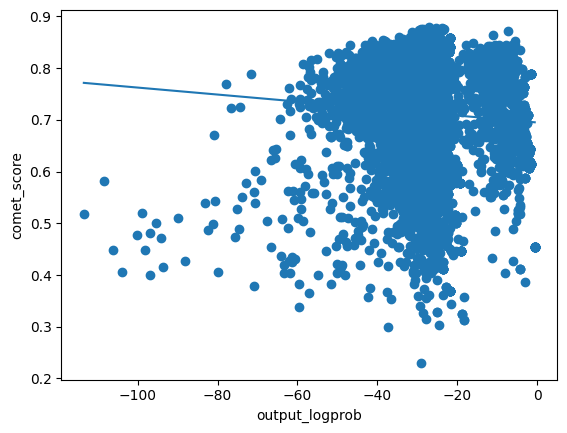

In [16]:
# examples_df
plot_keys(df=examples_df, xlabel='output_logprob', ylabel='comet_score')

In [17]:
for col in ['comet_score', 'output_logprob']:
    examples_df[col + '_norm'] = examples_df.groupby('instanceID')[col].transform(
        lambda x: (x - x.mean()) / x.std()
    )

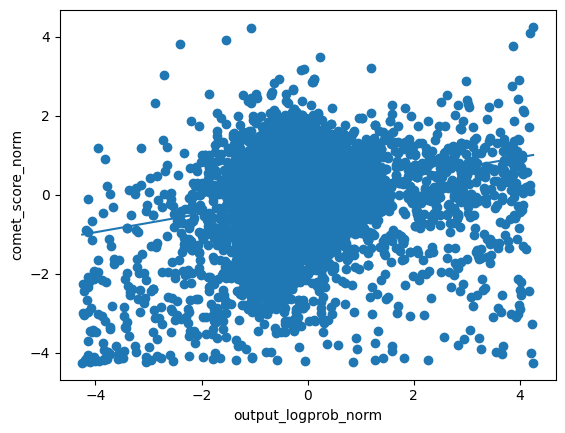

In [18]:
plot_keys(df=examples_df, xlabel='output_logprob_norm', ylabel='comet_score_norm')